<a href="https://colab.research.google.com/github/kakkia/final_project/blob/main/tf_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
import pathlib

data = "/content/drive/MyDrive/dataset"
dataset = pathlib.Path(data)
test = "/content/drive/MyDrive/validation"
test_ds = pathlib.Path(test)

In [3]:
batch_size = 32
img_height = 160
img_width = 160

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1007 files belonging to 3 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_ds,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 154 files belonging to 3 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['perfect', 'shoo', 'what']


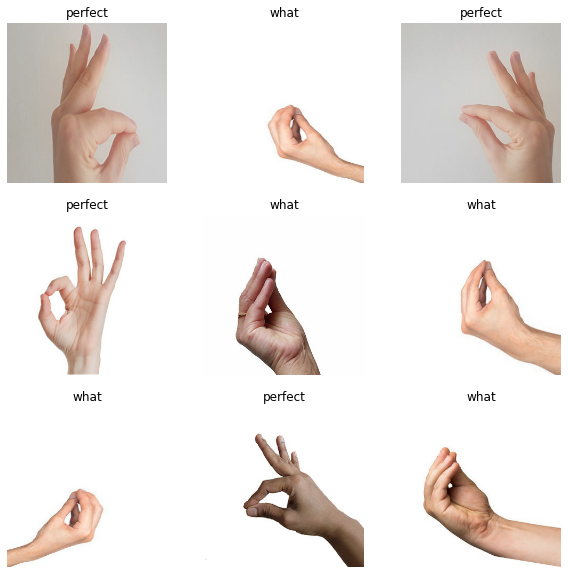

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [11]:
image_batch = image_batch.numpy()
labels_batch = labels_batch.numpy()

In [12]:
# adapting the code for tranfer learning following the tensorflow documentation 

val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


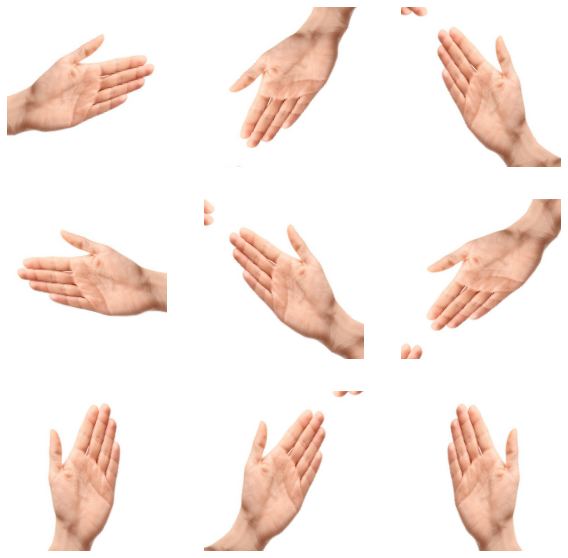

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [19]:
image_size=(img_height, img_width)

In [20]:
IMG_SIZE = image_size

In [21]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#model.compile(optimizer='adam',
 #             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #            metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [34]:
len(model.trainable_variables)

2

In [ ]:
# from here the code only works for binary classification 
# I changed to crossentropy but it does not work 

In [35]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 34s 488ms/step - loss: 2.5713 - accuracy: 0.2705


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.57
initial accuracy: 0.27


In [37]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
32/32 [==============================] - 111s 3s/step - loss: 1.6700 - accuracy: 0.3307 - val_loss: 1.2647 - val_accuracy: 0.3443
Epoch 2/10
32/32 [==============================] - 24s 705ms/step - loss: 1.2102 - accuracy: 0.3764 - val_loss: 1.0283 - val_accuracy: 0.4508
Epoch 3/10
32/32 [==============================] - 24s 729ms/step - loss: 1.0479 - accuracy: 0.4747 - val_loss: 0.9095 - val_accuracy: 0.5164
Epoch 4/10
32/32 [==============================] - 24s 746ms/step - loss: 0.9002 - accuracy: 0.5869 - val_loss: 0.8214 - val_accuracy: 0.6639
Epoch 5/10
32/32 [==============================] - 24s 728ms/step - loss: 0.8094 - accuracy: 0.6445 - val_loss: 0.7131 - val_accuracy: 0.7459
Epoch 6/10
32/32 [==============================] - 25s 762ms/step - loss: 0.7056 - accuracy: 0.7071 - val_loss: 0.6360 - val_accuracy: 0.8525
Epoch 7/10
32/32 [==============================] - 24s 717ms/step - loss: 0.6399 - accuracy: 0.7408 - val_loss: 0.5602 - val_accuracy: 0.9262
E

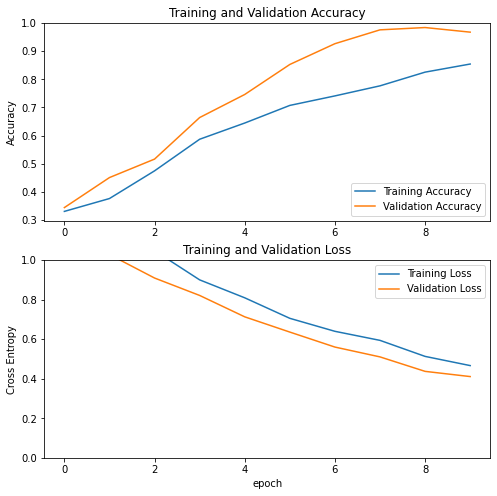

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [41]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [43]:
len(model.trainable_variables)

56

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
32/32 [==============================] - 42s 1s/step - loss: 1.9287 - accuracy: 0.3545 - val_loss: 1.1037 - val_accuracy: 0.4262
Epoch 11/20
32/32 [==============================] - 36s 1s/step - loss: 1.2510 - accuracy: 0.3337 - val_loss: 1.1389 - val_accuracy: 0.3033
Epoch 12/20
32/32 [==============================] - 36s 1s/step - loss: 1.2303 - accuracy: 0.3227 - val_loss: 1.0921 - val_accuracy: 0.3197
Epoch 13/20
32/32 [==============================] - 36s 1s/step - loss: 1.2201 - accuracy: 0.3059 - val_loss: 1.1247 - val_accuracy: 0.3525
Epoch 14/20
32/32 [==============================] - 36s 1s/step - loss: 1.1720 - accuracy: 0.3456 - val_loss: 1.1575 - val_accuracy: 0.2787
Epoch 15/20
32/32 [==============================] - 36s 1s/step - loss: 1.1527 - accuracy: 0.3337 - val_loss: 1.1439 - val_accuracy: 0.2869
Epoch 16/20
32/32 [==============================] - 36s 1s/step - loss: 1.1367 - accuracy: 0.3674 - val_loss: 1.1139 - val_accuracy: 0.3607
Epoch 17/20
3

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

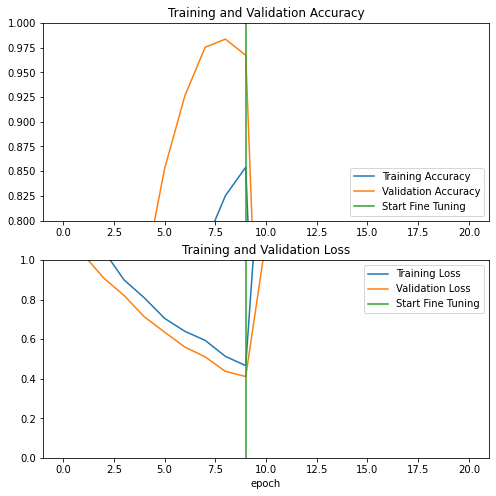

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 806ms/step - loss: 1.0995 - accuracy: 0.3438
Test accuracy : 0.34375


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [0 1 2 1 2 1 2 1 1 0 0 1 2 0 0 2 2 0 2 2 0 1 2 2 0 1 0 1 1 0 1 1]


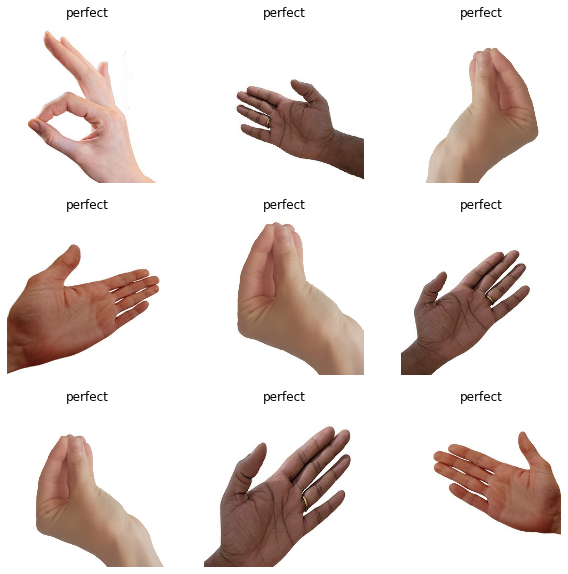

In [48]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# transfer learning is not working for me